# Model Setup

In [206]:
import numpy as np
import pandas as pd

import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

import math

plt.style.use('ggplot')
#Setup Configs
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [75]:
def from_pickle(fp):
    with open(fp, 'rb') as to_read: 
        return pickle.load(to_read)
    return None

## Load Data

In [76]:
X_live = from_pickle('/Users/alexanderparker/coding/colorado_og/pickles/X_live.pickle')
y_live = from_pickle('/Users/alexanderparker/coding/colorado_og/pickles/y_live.pickle')

In [218]:
all_obs = X_live.copy(deep=True)
all_obs['y_act'] = y_live

all_obs.columns = all_obs.columns.str.strip()

all_obs_fac_cat = all_obs[['facility_type_CENTRALIZED EP WASTE MGMT FAC','facility_type_FLOWLINE',
                                 'facility_type_GAS COMPRESSOR STATION','facility_type_GAS GATHERING PIPELINE SYSTEM',
                                'facility_type_GAS GATHERING SYSTEM','facility_type_GAS PROCESSING PLANT',
                                'facility_type_OFF-LOCATION FLOWLINE','facility_type_OIL AND GAS LOCATION',
                                'facility_type_OTHER','facility_type_PARTIALLY-BURIED VESSEL',
                                'facility_type_PIPELINE','facility_type_PIT',
                                'facility_type_PRODUCED WATER TRANSFER SYSTEM','facility_type_TANK BATTERY',
                                'facility_type_WATER GATHERING SYSTEM/LINE','facility_type_WELL',
                                'facility_type_WELL PAD']]

all_obs_land_cat = all_obs[['current_land_use_CROP LAND','current_land_use_NON-CROP LAND','current_land_use_OTHER']]

all_obs_own_cat = all_obs[['surface_owner_FEDERAL','surface_owner_FEE','surface_owner_OTHER',
                                 'surface_owner_STATE','surface_owner_TRIBAL']]

all_obs_cause_cat = all_obs[['human_error','equipment_failure','historical_unkown','other']]

all_obs['facility_type'] = all_obs_fac_cat.columns[np.where(all_obs_fac_cat==1)[1]]
all_obs['facility_type'] = all_obs['facility_type'].str.replace('facility_type_','')

all_obs['land_use'] = all_obs_land_cat.columns[np.where(all_obs_land_cat!=0)[1]]
all_obs['land_use'] = all_obs['land_use'].str.replace('current_land_use_','')

all_obs['surface_owner'] = all_obs_own_cat.columns[np.where(all_obs_own_cat!=0)[1]]
all_obs['surface_owner'] = all_obs['surface_owner'].str.replace('surface_owner_','')

for column in all_obs_cause_cat.columns:
    if sorted(all_obs_cause_cat[column].unique()) == [0,1]:
        all_obs_cause_cat[column] = all_obs_cause_cat[column].astype(bool)

all_obs_cause_cat['unknown'] = all_obs_cause_cat.apply(lambda row: True if not any(row) else False, axis=1)

def get_first(row):
    for column in row.index:
        if row[column]:
            return column

all_obs['cause'] = all_obs_cause_cat.apply(get_first, axis=1)


all_obs = all_obs.drop(columns=['facility_type_CENTRALIZED EP WASTE MGMT FAC','facility_type_FLOWLINE',
                                 'facility_type_GAS COMPRESSOR STATION','facility_type_GAS GATHERING PIPELINE SYSTEM',
                                'facility_type_GAS GATHERING SYSTEM','facility_type_GAS PROCESSING PLANT',
                                'facility_type_OFF-LOCATION FLOWLINE','facility_type_OIL AND GAS LOCATION',
                                'facility_type_OTHER','facility_type_PARTIALLY-BURIED VESSEL',
                                'facility_type_PIPELINE','facility_type_PIT',
                                'facility_type_PRODUCED WATER TRANSFER SYSTEM','facility_type_TANK BATTERY',
                                'facility_type_WATER GATHERING SYSTEM/LINE','facility_type_WELL',
                                'facility_type_WELL PAD','current_land_use_CROP LAND','current_land_use_NON-CROP LAND',
                                'current_land_use_OTHER','surface_owner_FEDERAL','surface_owner_FEE',
                                'surface_owner_OTHER', 'surface_owner_STATE','surface_owner_TRIBAL',
                                'human_error','equipment_failure','historical_unkown','other'])


for column in all_obs.columns:
    if sorted(all_obs[column].unique()) == [0,1]:
        all_obs[column] = all_obs[column].astype(bool)
        
all_obs.to_csv('all_obs.csv')

/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [221]:
for unique in all_obs['cause'].unique():
    print(unique)
    print(len(all_obs[all_obs['cause'] == unique]))

unknown
2964
equipment_failure
167
historical_unkown
135
human_error
70
other
13


## Load Models

In [77]:
# Models to Run 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [78]:
# Test Setup
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


In [79]:
model = KNeighborsClassifier()

In [80]:
type(model)

sklearn.neighbors.classification.KNeighborsClassifier

In [81]:
isinstance(model,KNeighborsClassifier)

True

In [82]:
def model_tune(model,X,y,cv=5,scoring='roc_auc',params=None):
    skip_flag = 0
    param_grid_dict = {
        KNeighborsClassifier : dict(n_neighbors=list(range(1, 31)), weights=['uniform', 'distance']),
        LogisticRegression : dict(C=[0.001,0.01,0.1,1,10,100]),
        LinearSVC: dict(C=[1, 10, 100, 1000]),
        SVC : {'kernel': ['rbf'], 'gamma': [1,1e-1,1e-2,1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
        DecisionTreeClassifier : dict(max_depth=list(range(1, 31)),
                                      min_samples_split=np.linspace(0.1, 1.0, 10, endpoint=True),
                                      min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)),
        RandomForestClassifier : dict(n_estimators= list(range(100,201,50)),
                                      max_features=['sqrt','log2',None])
        
    }
    
    if params:
        param_grid = params
    else:
        try:
            param_grid = param_grid_dict[type(model)]
        except KeyError:
            skip_flag = 1
    
    if not skip_flag:
        grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring)
        grid.fit(X,y)
        results_df = pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score']).reset_index(drop=True)
        top_model = grid.best_estimator_ 
        return {'top_model': top_model,'results' : results_df}
    else:
        print('No param_grid found for:')
        return {'top_model': model}
    
def model_list_tune(model_list,X,y,cv=5,scoring='roc_auc'):
    
    results_list = []
    
    for model in model_list:
        print(model)
        out = model_tune(model,X,y,cv=cv,scoring=scoring,params=None)
        if out:
            results_list.append(out)
            
    return results_list

def batch_cv(model_list,X,y,metrics,cv,cv_loops):
    df_list = []
    for model in model_list:
        for _ in range(0,cv_loops):
            cv_dict = cross_validate(model,X,y,scoring=metrics,cv=cv,return_train_score=True)
            cv_dict['model'] = [model for _ in cv_dict['fit_time']]
            df_list.append(pd.DataFrame(cv_dict))
            
    detail_df = pd.concat(df_list).reset_index(drop=True)
    summ_df = detail_df.groupby('model',sort=False).mean().reset_index()

    return [summ_df,detail_df]

In [83]:
model_list = [RandomForestClassifier(),DecisionTreeClassifier(),KNeighborsClassifier() ,LogisticRegression(),
              BernoulliNB(), LinearSVC(),
              SVC()]

X_train, X_val ,y_train, y_val = train_test_split(X_live,y_live,test_size=.2)

tuned_models = []

for model_res in model_list_tune(model_list,X_train,y_train):
    tuned_models.append(model_res['top_model'])
    
tuned_models

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_

/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packa

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=150,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=0.1, min_samples_split=0.1,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                

In [84]:
results = batch_cv(tuned_models,X_train,y_train,['roc_auc','accuracy','average_precision','f1'],5,5)

/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexanderparker/anaconda3/envs/metis/l

In [85]:
results[0]

,model,fit_time,score_time,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_average_precision,train_average_precision,test_f1,train_f1
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.697403,0.073969,0.743302,0.999924,0.685407,0.997387,0.682052,0.999914,0.668854,0.997242
1,"DecisionTreeClassifier(class_weight=None, crit...",0.003406,0.005153,0.682801,0.688629,0.649877,0.649870,0.617128,0.620671,0.624742,0.625078
2,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.003717,0.019683,0.570387,0.999985,0.542358,0.997387,0.531666,0.999973,0.517366,0.997239
3,"LogisticRegression(C=1, class_weight=None, dua...",0.006955,0.005160,0.732511,0.751977,0.678611,0.689063,0.675652,0.699556,0.660204,0.674900
4,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.003053,0.006396,0.718181,0.729149,0.665179,0.671519,0.656453,0.669800,0.650884,0.659171
5,"LinearSVC(C=1, class_weight=None, dual=True, f...",0.084565,0.005898,0.548959,0.539991,0.499360,0.499311,0.531995,0.521836,0.335765,0.336025
6,"SVC(C=1000, cache_size=200, class_weight=None,...",0.673493,0.166931,0.703272,0.835374,0.656967,0.761851,0.645744,0.800572,0.642913,0.752449


In [227]:
results[0]['model'].iloc[3]

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
eval_model = results[0]['model'].iloc[3]

In [87]:
X_val

,days_from_first,human_error,equipment_failure,historical_unkown,other,oil_spilled,condensate_spilled,flowback_spilled,water_spilled,waste_spilled,...,facility_type_WELL,facility_type_WELL PAD,current_land_use_CROP LAND,current_land_use_NON-CROP LAND,current_land_use_OTHER,surface_owner_FEDERAL,surface_owner_FEE,surface_owner_OTHER,surface_owner_STATE,surface_owner_TRIBAL
tracking_#,,,,,,,,,,,,,,,,,,,,,
401123150,2809,0,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,1,0,0,1,0,0,0
401218807,2953,0,1,0,0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,1,0,0,0
400929476,2473,0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,0
401753474,3506,0,0,0,0,1.0,0.0,0.0,1.0,0.0,...,1,0,0,0,1,0,1,0,0,0
400716334,2097,0,0,0,0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,0,0
401274411,3022,0,0,0,0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,0,0
400719168,2102,0,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,1,0,0,0
401722296,3477,0,0,1,0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,0,0
401603890,3363,0,0,0,0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,1,0,0,0


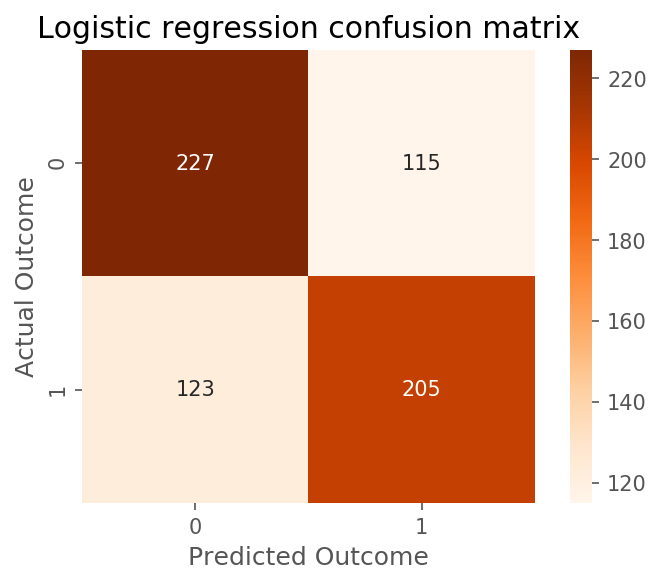

In [223]:
eval_model.fit(X_train,y_train)

# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(y_val, eval_model.predict(X_val))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Oranges, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('Logistic regression confusion matrix');

ROC AUC score =  0.7069872343460276


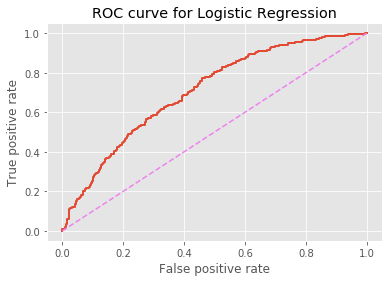

In [226]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_val, eval_model.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Logistic Regression');
print("ROC AUC score = ", roc_auc_score(y_val, eval_model.predict_proba(X_val)[:,1]))

In [97]:
# to json

json_df = X_val.copy(deep=True)
json_df['y_act'] = y_val
json_df['y_pred'] = eval_model.predict(X_val)
json_df['y_proba'] = eval_model.predict_proba(X_val)[:,1]
json_df['correct'] = json_df['y_act'] == json_df['y_pred']
json_df.head()

,days_from_first,human_error,equipment_failure,historical_unkown,other,oil_spilled,condensate_spilled,flowback_spilled,water_spilled,waste_spilled,...,current_land_use_OTHER,surface_owner_FEDERAL,surface_owner_FEE,surface_owner_OTHER,surface_owner_STATE,surface_owner_TRIBAL,y_act,y_pred,y_proba,correct
tracking_#,,,,,,,,,,,,,,,,,,,,,
401123150,2809,0,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,1,0.637524,False
401218807,2953,0,1,0,0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0.131264,True
400929476,2473,0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0.255528,False
401753474,3506,0,0,0,0,1.0,0.0,0.0,1.0,0.0,...,1,0,1,0,0,0,1,0,0.378559,False
400716334,2097,0,0,0,0,0.0,1.0,0.0,1.0,0.0,...,1,0,1,0,0,0,0,0,0.131356,True


In [108]:
def to_pickle(var,name,dir_name='pickles'):
    with open('{}/{}.pickle'.format(dir_name,name), 'wb') as to_write:
        pickle.dump(var, to_write)
        
to_pickle(json_df,'test_obs')

json_df.to_csv('test_obs.csv')

In [123]:
json_df_tf.columns

Index(['days_from_first', 'human_error', 'equipment_failure',
       'historical_unkown', 'other', 'oil_spilled', 'condensate_spilled',
       'flowback_spilled', 'water_spilled', 'waste_spilled', 'other_spilled',
       'drill_fluid_spilled', 'waters_of_the_state',
       'residence_/_occupied_structure', 'livestock', 'public_byway',
       'surface_water_supply_area', 'season_spring', 'season_summer',
       'season_winter', 'facility_type_CENTRALIZED EP WASTE MGMT FAC',
       'facility_type_FLOWLINE', 'facility_type_GAS COMPRESSOR STATION',
       'facility_type_GAS GATHERING PIPELINE SYSTEM',
       'facility_type_GAS GATHERING SYSTEM',
       'facility_type_GAS PROCESSING PLANT',
       'facility_type_OFF-LOCATION FLOWLINE',
       'facility_type_OIL AND GAS LOCATION', 'facility_type_OTHER',
       'facility_type_PARTIALLY-BURIED VESSEL', 'facility_type_PIPELINE',
       'facility_type_PIT', 'facility_type_PRODUCED WATER TRANSFER SYSTEM',
       'facility_type_TANK BATTERY',
    

In [191]:
json_df_tf = json_df.copy(deep=True)

json_df_tf.columns = json_df_tf.columns.str.strip()

json_df_tf_fac_cat = json_df_tf[['facility_type_CENTRALIZED EP WASTE MGMT FAC','facility_type_FLOWLINE',
                                 'facility_type_GAS COMPRESSOR STATION','facility_type_GAS GATHERING PIPELINE SYSTEM',
                                'facility_type_GAS GATHERING SYSTEM','facility_type_GAS PROCESSING PLANT',
                                'facility_type_OFF-LOCATION FLOWLINE','facility_type_OIL AND GAS LOCATION',
                                'facility_type_OTHER','facility_type_PARTIALLY-BURIED VESSEL',
                                'facility_type_PIPELINE','facility_type_PIT',
                                'facility_type_PRODUCED WATER TRANSFER SYSTEM','facility_type_TANK BATTERY',
                                'facility_type_WATER GATHERING SYSTEM/LINE','facility_type_WELL',
                                'facility_type_WELL PAD']]

json_df_tf_land_cat = json_df_tf[['current_land_use_CROP LAND','current_land_use_NON-CROP LAND','current_land_use_OTHER']]

json_df_tf_own_cat = json_df_tf[['surface_owner_FEDERAL','surface_owner_FEE','surface_owner_OTHER',
                                 'surface_owner_STATE','surface_owner_TRIBAL']]

json_df_tf_cause_cat = json_df_tf[['human_error','equipment_failure','historical_unkown','other']]

json_df_tf['facility_type'] = json_df_tf_fac_cat.columns[np.where(json_df_tf_fac_cat==1)[1]]
json_df_tf['facility_type'] = json_df_tf['facility_type'].str.replace('facility_type_','')

json_df_tf['land_use'] = json_df_tf_land_cat.columns[np.where(json_df_tf_land_cat!=0)[1]]
json_df_tf['land_use'] = json_df_tf['land_use'].str.replace('current_land_use_','')

json_df_tf['surface_owner'] = json_df_tf_own_cat.columns[np.where(json_df_tf_own_cat!=0)[1]]
json_df_tf['surface_owner'] = json_df_tf['surface_owner'].str.replace('surface_owner_','')

for column in json_df_tf_cause_cat.columns:
    if sorted(json_df_tf_cause_cat[column].unique()) == [0,1]:
        json_df_tf_cause_cat[column] = json_df_tf_cause_cat[column].astype(bool)

json_df_tf_cause_cat['unknown'] = json_df_tf_cause_cat.apply(lambda row: True if not any(row) else False, axis=1)

def get_first(row):
    for column in row.index:
        if row[column]:
            return column

json_df_tf['cause'] = json_df_tf_cause_cat.apply(get_first, axis=1)


json_df_tf = json_df_tf.drop(columns=['facility_type_CENTRALIZED EP WASTE MGMT FAC','facility_type_FLOWLINE',
                                 'facility_type_GAS COMPRESSOR STATION','facility_type_GAS GATHERING PIPELINE SYSTEM',
                                'facility_type_GAS GATHERING SYSTEM','facility_type_GAS PROCESSING PLANT',
                                'facility_type_OFF-LOCATION FLOWLINE','facility_type_OIL AND GAS LOCATION',
                                'facility_type_OTHER','facility_type_PARTIALLY-BURIED VESSEL',
                                'facility_type_PIPELINE','facility_type_PIT',
                                'facility_type_PRODUCED WATER TRANSFER SYSTEM','facility_type_TANK BATTERY',
                                'facility_type_WATER GATHERING SYSTEM/LINE','facility_type_WELL',
                                'facility_type_WELL PAD','current_land_use_CROP LAND','current_land_use_NON-CROP LAND',
                                'current_land_use_OTHER','surface_owner_FEDERAL','surface_owner_FEE',
                                'surface_owner_OTHER', 'surface_owner_STATE','surface_owner_TRIBAL',
                                'human_error','equipment_failure','historical_unkown','other'])


for column in json_df_tf.columns:
    if sorted(json_df_tf[column].unique()) == [0,1]:
        json_df_tf[column] = json_df_tf[column].astype(bool)
        
def error_cat(row):
    if ((row['y_act'] == 1) & (row['y_pred'] == 1)):
        return 'tp'
    if ((row['y_act'] == 0) & (row['y_pred'] == 1)):
        return 'fp' 
    if ((row['y_act'] == 0) & (row['y_pred'] == 0)):
        return 'tn'
    if ((row['y_act'] == 1) & (row['y_pred'] == 0)):
        return 'fn'

json_df_tf['error'] = json_df_tf.apply(error_cat,axis=1)
    
json_df_tf.to_csv('test_obs.csv')



/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [193]:
json_df_tf.head(5)

,days_from_first,oil_spilled,condensate_spilled,flowback_spilled,water_spilled,waste_spilled,other_spilled,drill_fluid_spilled,waters_of_the_state,residence_/_occupied_structure,livestock,public_byway,surface_water_supply_area,season_spring,season_summer,season_winter,y_act,y_pred,y_proba,correct,facility_type,land_use,surface_owner,cause,error
tracking_#,,,,,,,,,,,,,,,,,,,,,,,,,
401123150,2809,False,False,False,True,False,0.0,False,False,False,False,False,False,False,True,False,False,True,0.638,False,WELL PAD,NON-CROP LAND,FEE,unknown,fp
401218807,2953,True,True,False,True,False,0.0,False,False,False,False,False,False,False,False,True,False,False,0.131,True,FLOWLINE,CROP LAND,FEE,equipment_failure,tn
400929476,2473,True,False,False,False,False,1.0,False,True,False,False,False,False,False,False,True,True,False,0.256,False,FLOWLINE,CROP LAND,FEE,unknown,fn
401753474,3506,True,False,False,True,False,0.0,False,False,False,False,False,False,False,True,False,True,False,0.379,False,WELL,OTHER,FEE,unknown,fn
400716334,2097,False,True,False,True,False,0.0,False,True,False,False,False,False,False,True,False,False,False,0.131,True,FLOWLINE,OTHER,FEE,unknown,tn


In [204]:
melt_df = json_df_tf[['oil_spilled','condensate_spilled','flowback_spilled',
            'water_spilled','waste_spilled','other_spilled',
            'drill_fluid_spilled','y_act','y_pred']].melt(id_vars=['y_act','y_pred'], var_name="spill_type", value_name="tf")

melt_df['sum_on'] = 1

to_tableau = melt_df.groupby(['y_act','y_pred','spill_type','tf']).sum().reset_index()

to_tableau.to_csv('spill_tally.csv')

In [205]:
to_tableau

,y_act,y_pred,spill_type,tf,sum_on
0,False,False,condensate_spilled,False,107
1,False,False,condensate_spilled,True,120
2,False,False,drill_fluid_spilled,False,218
3,False,False,drill_fluid_spilled,True,9
4,False,False,flowback_spilled,False,216
5,False,False,flowback_spilled,True,11
6,False,False,oil_spilled,False,93
7,False,False,oil_spilled,True,134
8,False,False,other_spilled,False,200
9,False,False,other_spilled,True,27


In [186]:
to_prob(eval_model.intercept_[0])

0.46683006837099394

In [207]:
def to_prob(log_odd):
    return math.exp(eval_model.intercept_[0]+log_odd)/(1 + math.exp(eval_model.intercept_[0]+log_odd))

pd.Series(data=eval_model.coef_[0],index=X_train.columns).sort_values().apply(to_prob)

historical_unkown                                       0.137
facility_type_GAS GATHERING PIPELINE SYSTEM             0.235
waste_spilled                                           0.242
public_byway                                            0.270
condensate_spilled                                      0.273
waters_of_the_state                                     0.303
facility_type_PARTIALLY-BURIED VESSEL                   0.319
surface_owner_FEE                                       0.359
facility_type_PIPELINE                                  0.363
oil_spilled                                             0.376
equipment_failure                                       0.384
current_land_use_CROP LAND                              0.387
facility_type_WELL                                      0.400
facility_type_FLOWLINE                                  0.405
season_spring                                           0.425
surface_owner_STATE                                     0.439
facility

In [209]:
pd.Series(data=eval_model.coef_[0],index=X_train.columns).sort_values().apply(to_prob).to_csv('coefs.csv')

In [ ]:
eval_model.coef_[0]

In [105]:
def conf_matrix(df):
    tp = len(df[(df['y_act'] == 1) & (df['y_pred'] == 1)])
    fp = len(df[(df['y_act'] == 0) & (df['y_pred'] == 1)])
    tn = len(df[(df['y_act'] == 0) & (df['y_pred'] == 0)])
    fn = len(df[(df['y_act'] == 1) & (df['y_pred'] == 0)])
    return [[tp,fn],[fp,tn]]

In [106]:
conf_matrix(json_df)

[[205, 123], [115, 227]]

In [214]:
sum(y_train)

1270

In [215]:
len(y_train)

2679

In [216]:
1270/2679

0.4740574841358716